In [1]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
titanic_df = pd.read_csv('train.csv')

In [3]:
def male_female_child(passenger):
    # 年齢と性別のデータを取得します。
    age,sex = passenger
    # 年齢を調べて16歳未満なら、子供。それ以外は性別をそのまま返します。
    if age < 16:
        return 3
    else:
        if sex == 'male':
            return 1
        else:
            return 2
    
# personという新しい列を追加します。
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(male_female_child,axis=1)

In [4]:
titanic_df['Alone'] = titanic_df.Parch + titanic_df.SibSp

In [5]:
titanic_df['Alone'].loc[titanic_df['Alone'] >0] = 1
titanic_df['Alone'].loc[titanic_df['Alone'] == 0] = 0

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
train_data = titanic_df.drop(['PassengerId','Name','Sex','SibSp','Parch','Fare', 'Ticket', 'Cabin', 'Embarked'], 1)

In [7]:
train_data = train_data.dropna()

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 5 columns):
Survived    714 non-null int64
Pclass      714 non-null int64
Age         714 non-null float64
Person      714 non-null int64
Alone       714 non-null int64
dtypes: float64(1), int64(4)
memory usage: 33.5 KB


In [9]:
t = train_data.iloc[:,0]
x = train_data.iloc[:,1:]

In [10]:
x = x.values

In [11]:
x = x.astype("f")
t = t.astype("i")

In [12]:
dataset = list(zip(x, t))

In [13]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainer
import cupy

from chainer import training
from chainer.training import extensions

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
n_train = int(len(dataset)*0.7)

In [15]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=1)

In [47]:
class NN(chainer.Chain):
    def __init__(self, n_mid_units1=3, n_out=2):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units1)
            self.fc2 = L.Linear(None, n_out)
            
            self.bn = L.BatchNormalization(4)
    
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [48]:
np.random.seed(1)
nn = NN()
model = L.Classifier(nn)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
batch_size = 20

In [49]:
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

In [50]:
updater = training.StandardUpdater(train_iter, optimizer, device=0)

In [51]:
epoch = 100

In [52]:
trainer = training.Trainer(updater, (epoch, "epoch"), out="result/titanic")

trainer.extend(extensions.Evaluator(test_iter, model, device=0))
trainer.extend(extensions.LogReport(trigger=(1, "epoch")))
trainer.extend(extensions.PrintReport(["epoch", "main/accuracy", "validation/main/accuracy", "main/loss", "validation/main/loss"]))

In [53]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss
1           0.416          0.434848                  0.868425    0.836271              
2           0.43           0.412121                  0.821492    0.8191                
3           0.452          0.456061                  0.783691    0.782928              
4           0.48           0.469697                  0.76521     0.755808              
5           0.506          0.469697                  0.736462    0.733053              
6           0.518          0.528788                  0.712116    0.717381              
7           0.54           0.557576                  0.70763     0.704784              
8           0.56           0.60303                   0.694201    0.685546              
9           0.574          0.607576                  0.683885    0.676046              
10          0.59           0.607576                  0.668602    0.66505               
11          0.596          0.61363

91          0.802          0.784848                  0.416609    0.435202              
92          0.8            0.780303                  0.430831    0.435568              
93          0.81           0.757576                  0.437976    0.442375              
94          0.794          0.80303                   0.448092    0.428904              
95          0.794          0.784848                  0.420013    0.43037               
96          0.792          0.807576                  0.441509    0.428584              
97          0.816          0.784848                  0.413497    0.432372              
98          0.824          0.780303                  0.429978    0.434712              
99          0.814          0.807576                  0.435934    0.429436              
100         0.802083       0.795455                  0.424688    0.429562              


In [54]:
import json

In [55]:
with open("result/titanic/log") as f:
    logs = json.load(f)

In [56]:
results = pd.DataFrame(logs)

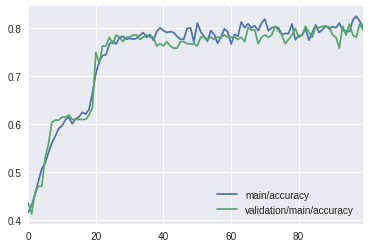

In [57]:
%matplotlib inline
results[["main/accuracy", "validation/main/accuracy"]].plot()